In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import tensorflow as tf
import plotly.express as px

from matplotlib import cm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Data Preprocessing Steps

To prepare the dataset for subsequent processing, the following steps were performed:

1. **Standardize Column Name Formats**:
   - Column names were reformatted to ensure consistency (e.g., using lowercase, replacing spaces with underscores, removing special characters) for easier handling in downstream tasks.

2. **Remove Duplicate Records**:
   - Duplicate rows were identified and removed to eliminate redundant data, ensuring each record is unique.

3. **Convert Data Columns to Appropriate Data Types**:
   - Columns were inspected and converted to their appropriate data types (e.g., numerical columns to float or int, categorical columns to string or category, dates to datetime) to facilitate accurate analysis and modeling.

4. **Remove Unnecessary Columns**:
   - Constant columns (with the same value for all records) and redundant columns (providing no additional information) were identified and dropped to reduce noise and optimize the dataset for processing.



In [2]:
# Read data
df = pd.read_csv('Food Security Indicators.csv', encoding='utf-8')

# Unify column name format: all lowercase, use underscores to replace spaces, remove content in parentheses
df.columns = [re.sub(r"\s*\([^)]*\)", "", col) for col in df.columns]        
df.columns = [col.strip().replace(" ", "_").lower() for col in df.columns]  

# Delete duplicate rows
df = df.drop_duplicates()

# Convert data types: convert columns representing numeric values to numeric types
# 
df['value'] = df['value'].replace('<2.5', 2.5)
df['value'] = pd.to_numeric(df['value'], errors='coerce')
# Add a numeric year column (using the end year of the range as the representative year)
df['Year_num'] = df['year'].apply(lambda y: int(y.split('-')[-1]) if '-' in y else int(y))

# Remove unnecessary columns: domain code, domain name, element code/name, unit, area code, etc.
cols_to_drop = ['domain_code', 'domain', 'element_code', 'element', 
                'unit', 'flag_description', 'area_code', 'item_code', 'year_code']
df.drop(columns=cols_to_drop, inplace=True)

df


,area,item,year,value,flag,note,Year_num
0,Low-income economies,Average dietary energy supply adequacy (percen...,2000-2002,94.0,E,NaN,2002
1,Low-income economies,Average dietary energy supply adequacy (percen...,2001-2003,94.0,E,NaN,2003
2,Low-income economies,Average dietary energy supply adequacy (percen...,2002-2004,95.0,E,NaN,2004
3,Low-income economies,Average dietary energy supply adequacy (percen...,2003-2005,96.0,E,NaN,2005
4,Low-income economies,Average dietary energy supply adequacy (percen...,2004-2006,96.0,E,NaN,2006
...,...,...,...,...,...,...,...
3875,Upper-middle-income economies,Average fat supply (g/cap/day) (3-year average),2016-2018,90.8,E,NaN,2018
3876,Upper-middle-income economies,Average fat supply (g/cap/day) (3-year average),2017-2019,92.5,E,NaN,2019
3877,Upper-middle-income economies,Average fat supply (g/cap/day) (3-year average),2018-2020,94.2,E,NaN,2020
3878,Upper-middle-income economies,Average fat supply (g/cap/day) (3-year average),2019-2021,96.7,E,NaN,2021


# Data Imputation and Comparison

To handle missing values in the dataset while preserving the ability to compare pre- and post-imputation data, the following steps were applied:

1. **Retention of Original Columns**:
   - Before imputation, copies of the original data columns (numerical column `value` and categorical column `note`) were retained to enable comparison of differences before and after imputation.

2. **Imputation for Numerical Column (`value`)**:
   - Missing values in the `value` column were imputed using appropriate statistical measures (e.g., mean, median, or mode, depending on the data distribution) to ensure numerical consistency and minimize bias.

3. **Imputation for Categorical Column (`note`)**:
   - Missing values in the `note` column were filled with a constant value (e.g., a predefined category or placeholder like "Unknown") to maintain categorical integrity.



In [3]:
# Fill missing values:
df['value_before'] = df['value']

# Fill missing values in the numerical column 'value' by calculating the median grouped by the indicator (item)
# If all values for a certain indicator in a region are missing, use the global median of that indicator instead
group_median = df.groupby(['area','item'])['value'].transform('median')
item_median = df.groupby('item')['value'].transform('median')
df['value'] = df['value'].fillna(group_median)
df['value'] = df['value'].fillna(item_median)

# The category column note fills missing values with the constant "No note"
df['note'] = df['note'].fillna('No note')

# Data Transformation Steps

To prepare the dataset for modeling, the following data transformation steps were applied to handle categorical and numerical variables:

1. **Label Encoding**:
   - The binary categorical variable `note` was converted into 0/1 values:
     - `0`: Represents the original value “Based on FY 2024 Classification”.
     - `1`: Represents “No note”.

2. **One-Hot Encoding**:
   - One-hot encoding was applied to the categorical columns `area` (region category), `item` (indicator category), and `flag` (data marker) to generate dummy variable columns, enabling proper representation of categorical data for modeling.

3. **Numerical Standardization**:
   - The `year` information was converted into a numerical intermediate year.
   - The numerical year values were standardized using Z-score normalization to eliminate the influence of scale, ensuring consistency in the feature space.

In [4]:
# Label code note column (binary)
le = LabelEncoder()
df['note_label'] = le.fit_transform(df['note'])
print("Note column label encoding mapping:", list(zip(le.classes_, le.transform(le.classes_))))
# Delete the original note column
df.drop(columns=['note'], inplace=True)

# Convert the Year column to numeric year and standardize
# Extract the midpoint of the year range as the representative year
def year_to_mid(year_str):
    if '-' in year_str:
        start, end = year_str.split('-')
        try:
            start, end = int(start), int(end)
            return (start + end) / 2.0 
        except:
            return None
    else:
        try:
            return float(year_str)
        except:
            return None

df['year_mid'] = df['year'].astype(str).apply(year_to_mid)

# Use StandardScaler to standardize (z-score) the year_mid column
scaler = StandardScaler()
df['year_scaled'] = scaler.fit_transform(df[['year_mid']])

# Use StandardScaler to standardize (z-score) the year_mid column
df.drop(columns=['year', 'year_mid'], inplace=True)

# One-hot encoding categorical variables area, item, flag
df_processed = pd.get_dummies(df, columns=['area', 'item', 'flag'], drop_first=False)

# View the dimensional changes after one-hot encoding
print("Shape of data after unique thermal encoding:", df_processed.shape)

# Show first 5 rows (some columns) of processed data
print(df_processed.head(5))

Note column label encoding mapping: [('Based on FY 2024 Classification', np.int64(0)), ('No note', np.int64(1))]
Shape of data after unique thermal encoding: (3880, 75)
   value  Year_num  value_before  note_label  year_scaled  \
0   94.0      2002          94.0           1    -1.840863   
1   94.0      2003          94.0           1    -1.689429   
2   95.0      2004          95.0           1    -1.537995   
3   96.0      2005          96.0           1    -1.386560   
4   96.0      2006          96.0           1    -1.235126   

   area_High-income economies  area_Low-income economies  \
0                       False                       True   
1                       False                       True   
2                       False                       True   
3                       False                       True   
4                       False                       True   

   area_Lower-middle-income economies  area_Upper-middle-income economies  \
0                         

Use the random forest model to evaluate the importance of each feature and select the top 10 fields ranked by feature importance.

In [5]:
# Split the processed dataset into feature matrix X and target variable y
X = df_processed.drop(columns=['value'])
y = df_processed['value']

# Train a random forest regression model to calculate feature importance
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Extract feature importances and sort them
importances = model.feature_importances_
feature_names = X.columns
top10_idx = np.argsort(importances)[-10:][::-1]  # Sort by importance and take top 10 indices
top10_features = feature_names[top10_idx]
top10_importances = importances[top10_idx]

print("Top 10 features by importance and their scores:")
for feat, imp in zip(top10_features, top10_importances):
    print(f"{feat}: {imp:.4f}")

Top 10 features by importance and their scores:
value_before: 0.9967
year_scaled: 0.0017
Year_num: 0.0015
flag_E: 0.0001
flag_Q: 0.0000
area_Lower-middle-income economies: 0.0000
item_Gross domestic product per capita, PPP, (constant 2017 international $): 0.0000
flag_X: 0.0000
area_Upper-middle-income economies: 0.0000
area_High-income economies: 0.0000


# Economic Indicators: Trends Over Time

We have selected several key indicators to analyze economic performance across different income levels. The trends for these indicators are visualized using **line graphs**, with each graph representing economies categorized into **four income levels** (low, lower-middle, upper-middle, and high). Each line within a graph corresponds to one of these income levels, enabling a clear comparison of economic trends across regions over time.

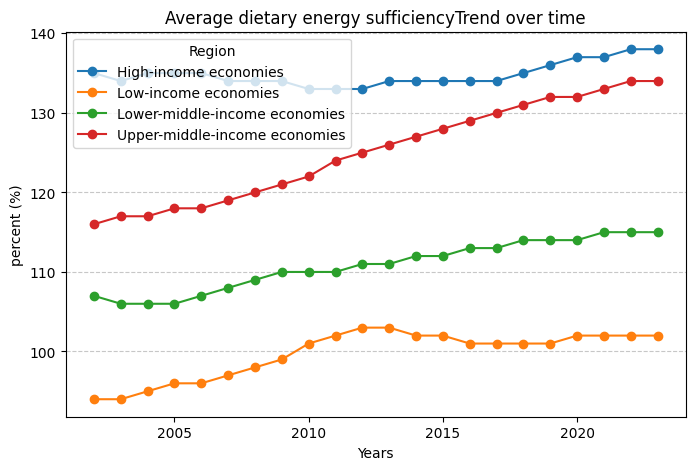

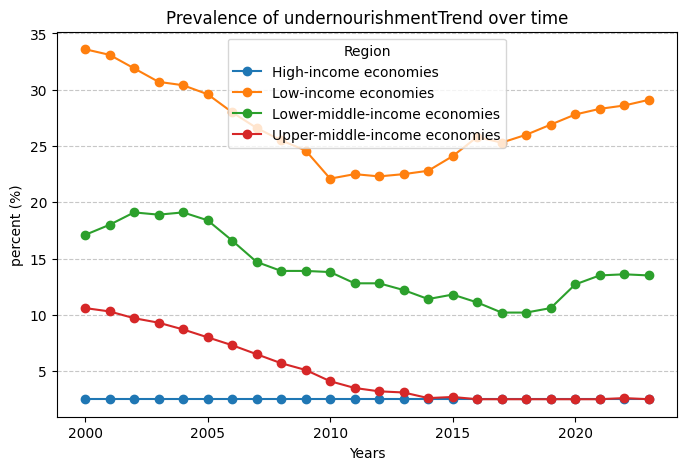

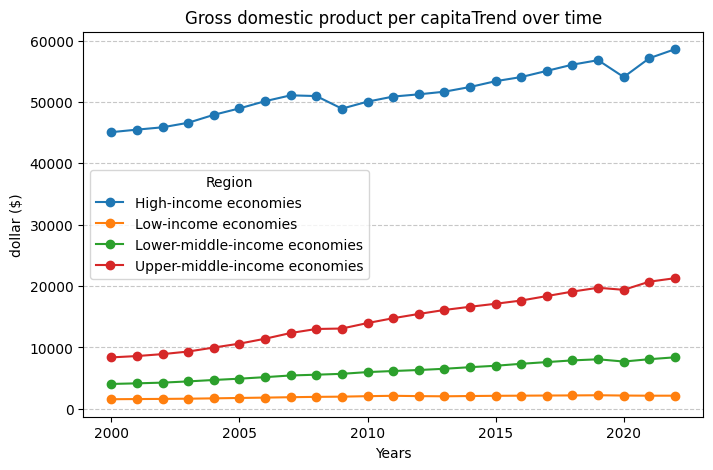

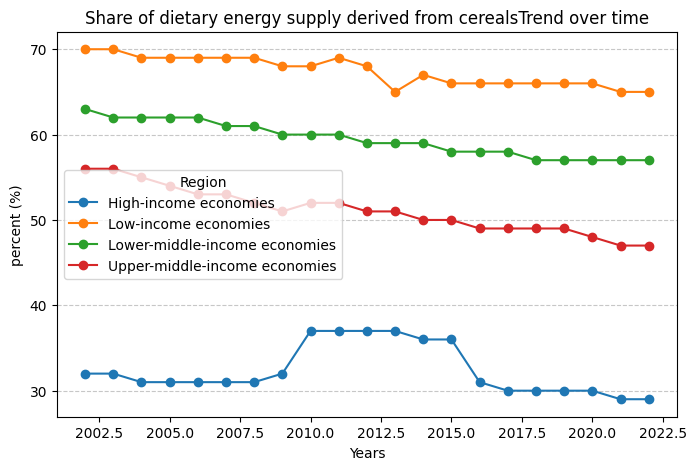

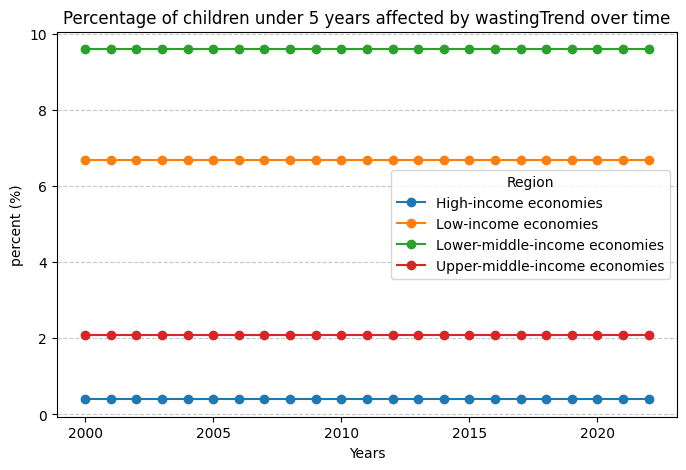

In [6]:
# List of indicators showing trends (
indicators_for_trend = [
    ("Average dietary energy supply adequacy (percent) (3-year average)", "Average dietary energy sufficiency", "percent (%)"),
    ("Prevalence of undernourishment (percent) (annual value)", "Prevalence of undernourishment", "percent (%)"),
    ("Gross domestic product per capita, PPP, (constant 2017 international $)", "Gross domestic product per capita", "dollar ($)"),
    ("Share of dietary energy supply derived from cereals, roots and tubers (percent) (3-year average)", "Share of dietary energy supply derived from cereals", "percent (%)"),
    ("Percentage of children under 5 years affected by wasting (percent)", "Percentage of children under 5 years affected by wasting", "percent (%)")
]

# Plot time trend line charts for each indicator one by one
for item, name, y_label in indicators_for_trend:
    # Extract all yearly data for the indicator and aggregate regions by Year_num
    sub = df[df['item'] == item]
    pivot_line = sub.pivot(index='Year_num', columns='area', values='value').sort_index()

    plt.figure(figsize=(8, 5))
    for region in pivot_line.columns:
        plt.plot(pivot_line.index, pivot_line[region], marker='o', label=region)
    plt.title(f"{name}Trend over time")
    plt.xlabel("Years")
    plt.ylabel(y_label)
    plt.legend(title="Region")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Trends in Food Security, Nutritional Status, and Economic Levels Across Income Groups

The following five line graphs illustrate the evolving trends of four major income groups—**high-income**, **upper-middle-income**, **lower-middle-income**, and **low-income economies**—in terms of food security, nutritional status, and economic level from 2000 to 2022. Each graph uses distinct lines to represent the four income groups, allowing for a comparative analysis of trends over time.

---

## 1. Average Dietary Energy Sufficiency
- **Overall Level**: Sufficiency rates range between 94% and 138% across all income groups.
  - **High-income economies**: Consistently the highest, increasing from ~133% to 138%.
  - **Low-income economies**: The lowest, improving from ~94% to 102%.
- **Trend**:
  - **High-, upper-middle-, and lower-middle-income groups**: Show a slow upward trend, with the upper-middle-income group rising significantly from ~116% to 134%.
  - **Low-income group**: Rapid improvement from 94% in 2000 to 103% by 2012, then stabilizing between 101% and 103%.

---

## 2. Prevalence of Undernourishment
- **Overall Level**:
  - **High-income group**: Very low, stable at ~2.5%.
  - **Upper-middle-income group**: Declined from ~10.7% to 2.5%.
  - **Lower-middle-income group**: Decreased from 17% to 13.6%.
  - **Low-income group**: Highest, dropping from ~34% to 29% but with a rebound.
- **Trend**:
  - **Upper-middle- and lower-middle-income groups**: Sharp decline from 2000 to 2010 (upper-middle: 10% to 4%), stabilizing at 2%–3% thereafter.
  - **Low-income group**: Significant drop from 34% to 22% between 2000 and 2010, followed by a rebound and fluctuations, reaching ~29% by 2022.

---

## 3. Gross Domestic Product per Capita (GDP per Capita)
- **Overall Level**:
  - **High-income group**: Stable, growing from $45,000 to $59,000.
  - **Upper-middle-income group**: Increased from $8,500 to $21,500.
  - **Lower-middle-income group**: Rose from $4,000 to $8,500.
  - **Low-income group**: Slow growth from $1,500 to $2,200.
- **Trend**:
  - All groups show continuous growth, except for a brief decline in the high-income group during the 2008–2009 global financial crisis, followed by recovery.
  - Middle-income groups, especially the upper-middle-income group, exhibit higher growth rates (~5%+ annually) compared to high- and low-income groups.

---

## 4. Share of Dietary Energy Supply Derived from Cereals
- **Overall Level**:
  - **Low-income group**: High reliance on cereals, declining from ~69% to 65%.
  - **Lower-middle-income group**: Decreased from ~63% to 57%.
  - **Upper-middle-income group**: Dropped from ~56% to 47%.
  - **High-income group**: Lowest, fluctuating between 31% and 37%.
- **Trend**:
  - All groups show a declining trend, particularly noticeable between 2008 and 2015.
  - **Low-income group**: Dropped from 70% to 65%.
  - **Upper-middle-income group**: Significant decline from 56% to 47%.
  - **High-income group**: Slight fluctuations with no clear long-term trend.

---

## 5. Wasting Rate Among Children Under 5 Years Old
- **Overall Level**:
  - **High-income group**: Consistently very low at ~0.4%.
  - **Upper-middle-income group**: Stable at ~2%.
  - **Lower-middle-income group**: ~9.6%.
  - **Low-income group**: ~6.7%.
- **Trend**:
  - All groups show minimal change, with fluctuations of less than 0.1 percentage points from 2000 to 2022, indicating stable wasting rates.

---

## Comprehensive Summary
- **Economic Growth (Figure 3)**: Economic growth underpins improvements in nutrition, but disparities persist in translating economic gains into nutritional outcomes. High- and middle-income groups have achieved sufficient energy intake and low hunger rates, while low-income groups face stalled progress and persistent wasting issues.
- **Dietary Structure and Malnutrition (Figures 4 and 5)**: Improvements in dietary structure and acute malnutrition indicators are slow. Addressing both the **quantity** (energy sufficiency) and **quality** (diversified diets, reduced wasting) of nutrition remains a significant challenge, particularly for low-income economies.

# Pearson correlation coefficients between  food safety indicators

We calculated **Pearson correlation coefficients** between all **food safety indicators** and visualized the **correlation matrix** using a **heat map**. The closer the color is to **red**, the stronger the **positive correlation**; the closer the color is to **blue**, the stronger the **negative correlation**; and the color closer to the **center (near white)** indicates a **weak or near zero correlation**.

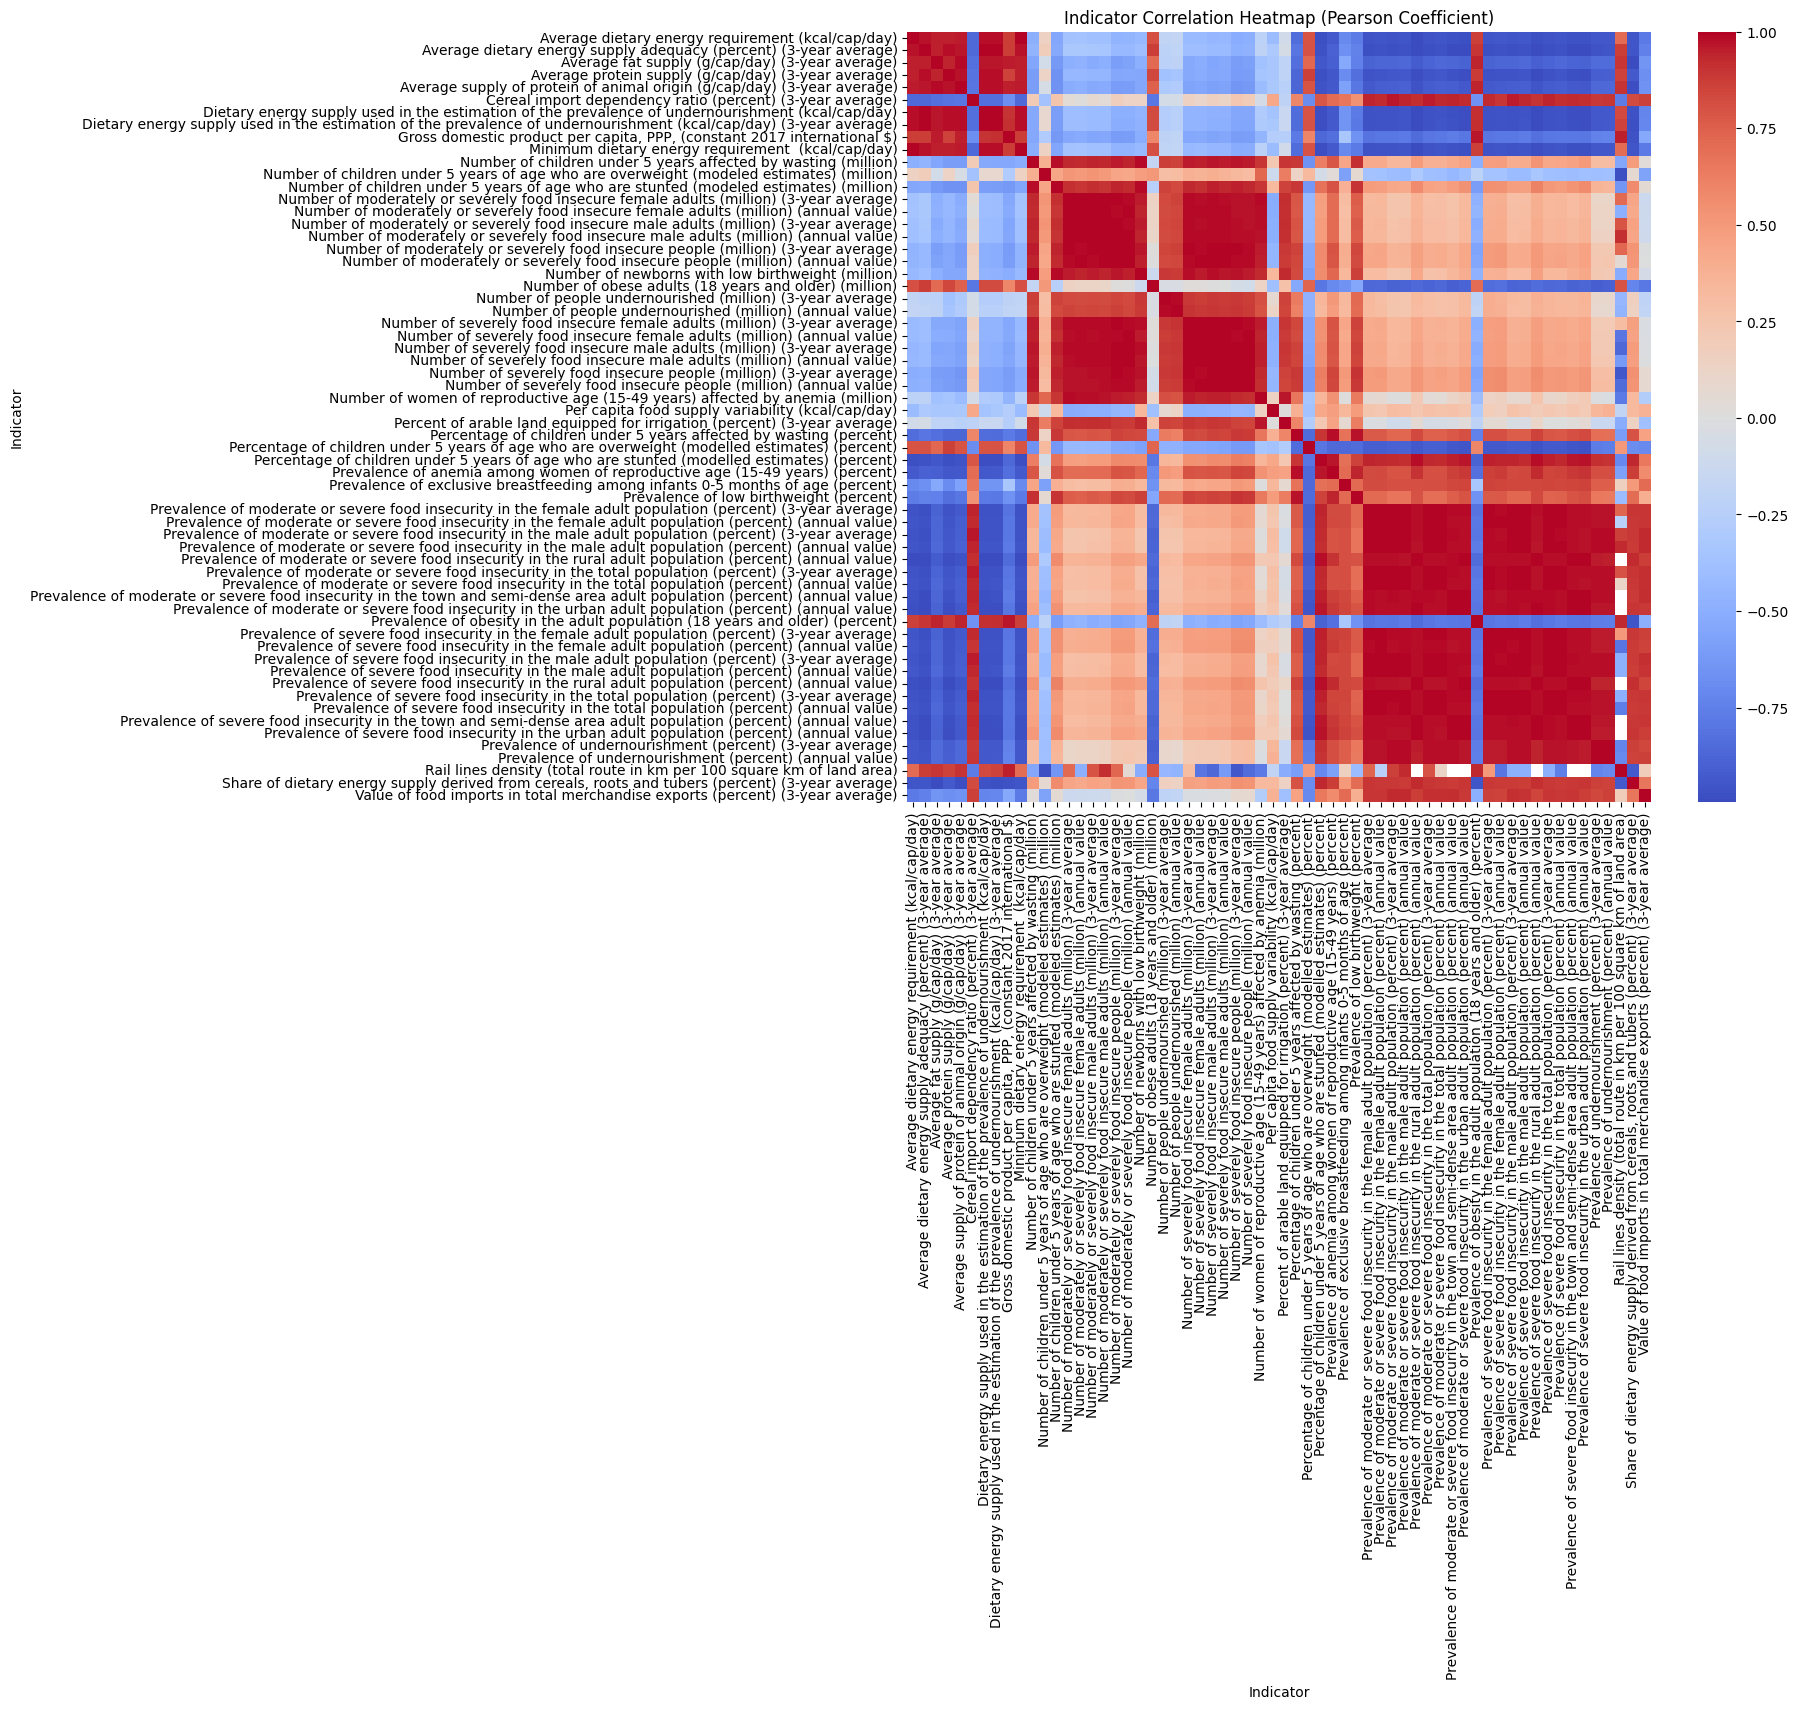

In [7]:
# Calculate the Pearson correlation coefficient matrix between indicators
data_by_year = df.pivot(index=['area', 'Year_num'], columns='item', values='value')
corr_matrix = data_by_year.corr(method='pearson', numeric_only=True)

# Plot the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
            xticklabels=True, yticklabels=True)
plt.title('Indicator Correlation Heatmap (Pearson Coefficient)')
plt.xlabel('Indicator')
plt.ylabel('Indicator')
plt.show()

# Heatmap Analysis: Pearson Correlation Coefficients for Food Security, Nutrition, and Economic Indicators

The heatmap displays Pearson correlation coefficients between various food security, nutrition, and economic indicators, with color intensity indicating correlation strength (red: strong positive correlation; blue: strong negative correlation). Cluster distribution reveals key insights into the relationships between these indicators. The main findings are summarized below:

Overall, the heatmap validates the intuitive relationship: **"High GDP → More accessible food → Better nutrition → Less hunger."** It also emphasizes the importance of supply diversification and comprehensive protection of vulnerable groups to enhance nutritional security.

---

## Key Findings

1. **Energy and Nutrition Supply Indicators Are Highly Positively Correlated**
   - Macronutrient supply indicators, such as **"average dietary energy requirement fulfillment"** and **"average fat/protein supply,"** exhibit deep red colors among themselves.
   - This indicates that energy, protein, and fat supplies fluctuate strongly in the same direction: in years when a country has sufficient energy supply, protein and fat supplies are typically adequate as well.

2. **Nutrition Supply vs. Hunger/Insecurity Are Strongly Negatively Correlated**
   - Supply indicators (energy, protein, fat) show deep blue blocks when paired with indicators of hunger or food insecurity, such as **"prevalence of malnutrition"** and **"moderate to severe food insecurity rate."**
   - This reflects a near mirror-image inverse relationship: better nutrition supply correlates with fewer issues of hunger and food insecurity.

3. **Economic Indicator (GDP per Capita) Is Positively Correlated with Nutrition Security**
   - **"Per capita GDP (PPP)"** shows a clear positive correlation (red) with energy/protein supply and a clear negative correlation (blue) with hunger and food insecurity rates.
   - This suggests that stronger economic capacity enhances cash flow and infrastructure, supporting improved nutrition security for the population.

4. **Grain Dependency Is Negatively Correlated with Diversity/Nutrition Security**
   - The indicator **"proportion of energy supplied by cereals"** shows a mild negative correlation (light blue) with energy/protein supply and a mild positive correlation (light red) with food insecurity indicators.
   - This reflects that regions overly reliant on cereals often face insufficient total energy and nutritional diversity, making them more prone to hunger or malnutrition.

5. **Sub-Indicators of Food Insecurity Are Highly Homogeneously Clustered**
   - In the lower middle area of the heatmap, sub-indicators of moderate to severe food insecurity among vulnerable groups (e.g., **wasting children**, **adult women**, **rural/urban populations**) show deep red correlations with each other.
   - This high degree of overlap indicates that groups heavily affected in one population segment are also likely to experience severe conditions in others.



# Scatterplot Matrix Analysis: Relationships Between Food Security, Nutrition, and Economic Indicators

A scatterplot matrix (pairplot) was utilized to examine the relationships between selected indicators, including **dietary energy sufficiency**, **malnutrition**, **acute food insecurity**, **staple food supply**, **wasting among children under 5**, and **GDP per capita**. Each subplot in the scatterplot matrix represents the scatter relationship between two indicators, with the color of the dots differentiated by region type. Histograms on the diagonal display the distribution of individual indicators.


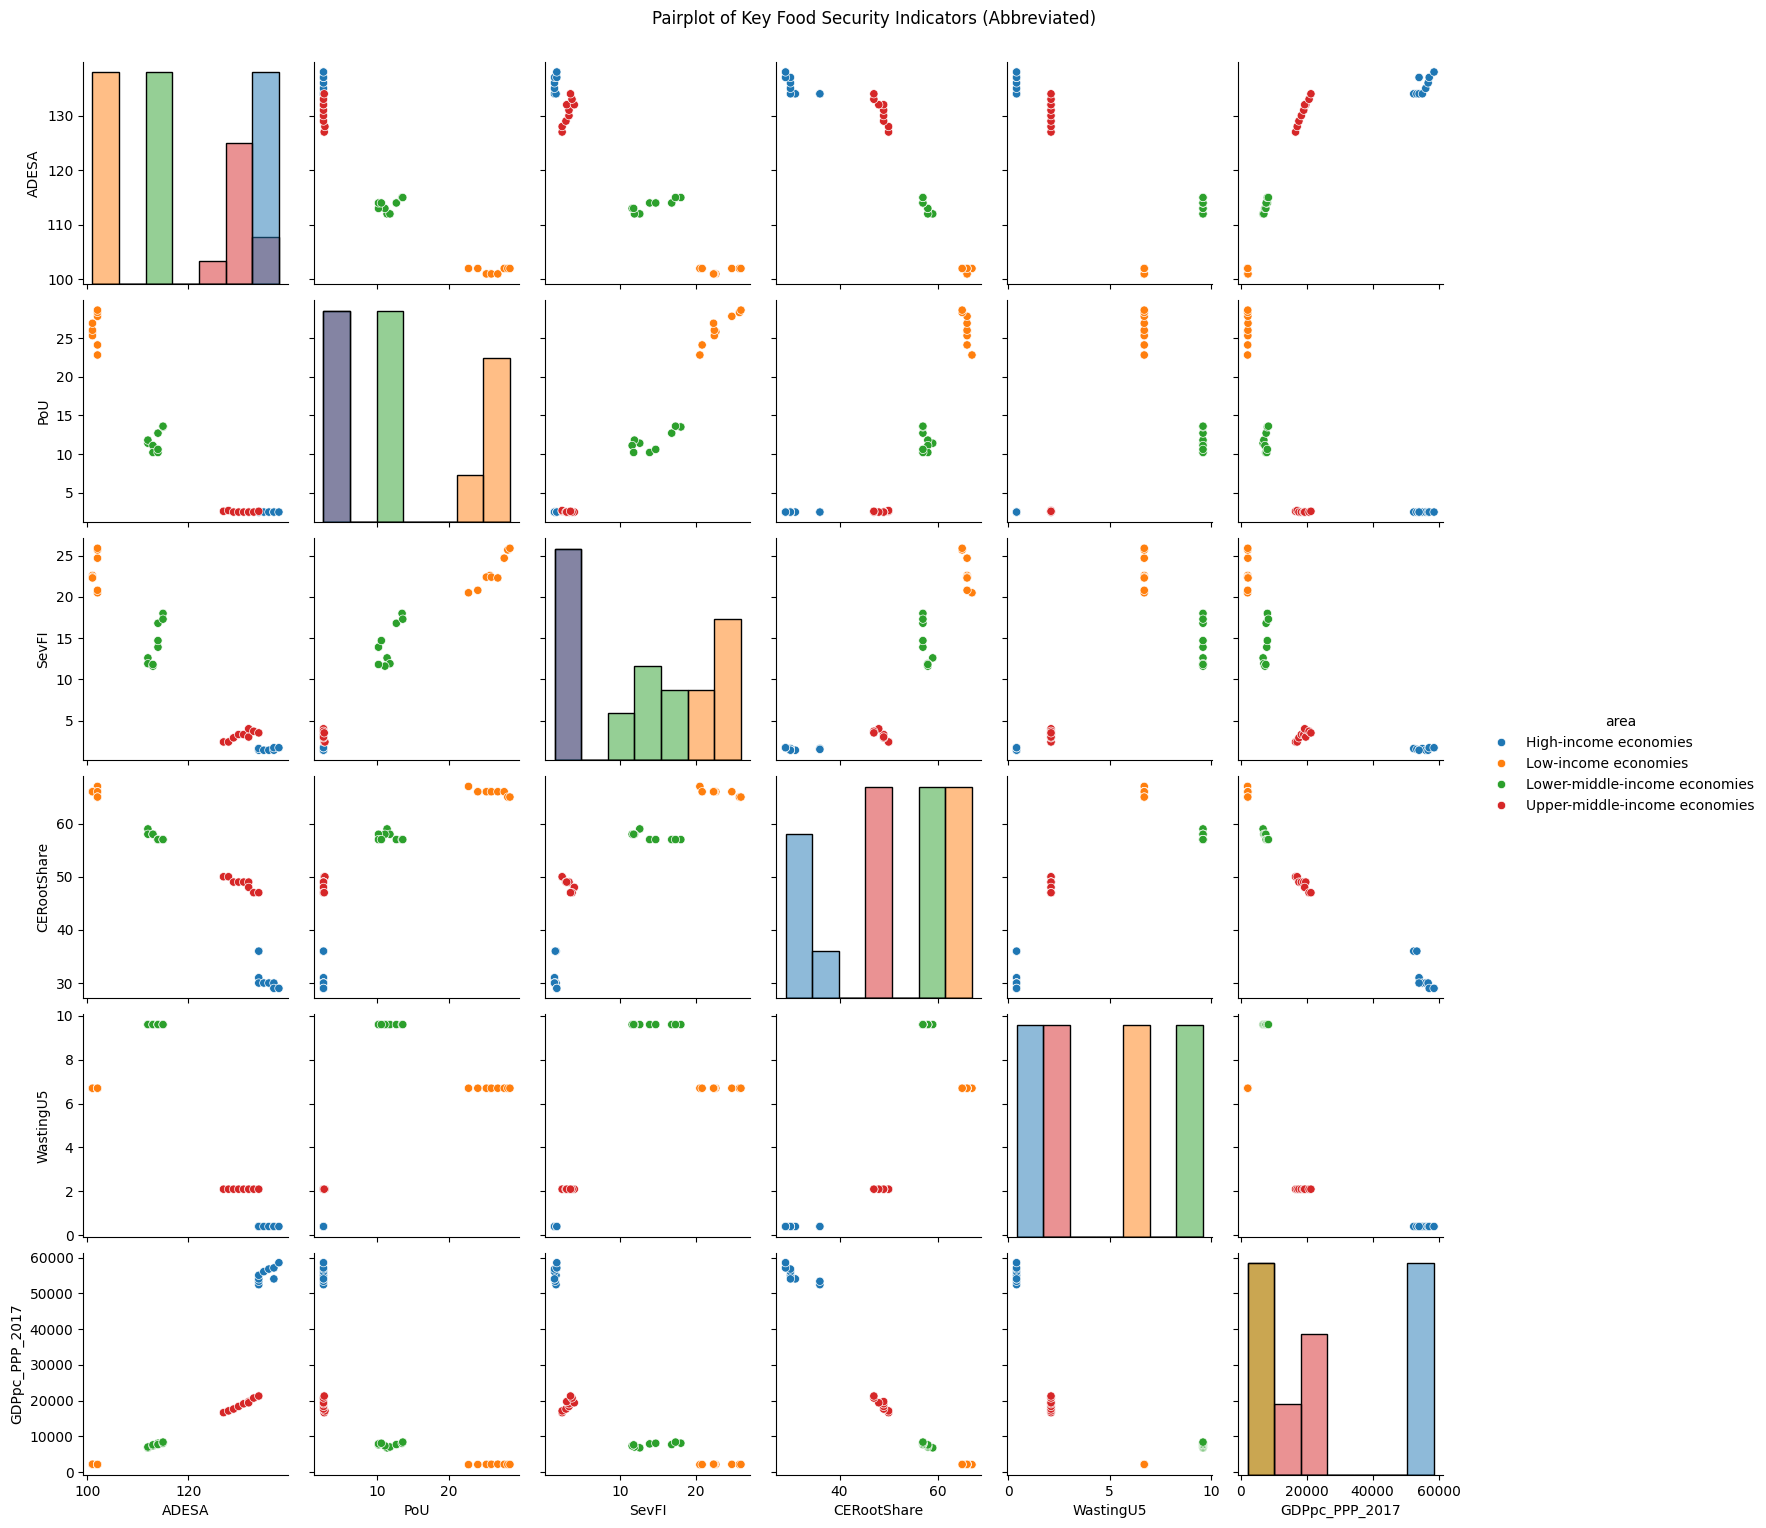

In [8]:
# Mapping of original column names to abbreviations
column_renames = {
    "Average dietary energy supply adequacy (percent) (3-year average)": "ADESA",
    "Prevalence of undernourishment (percent) (annual value)": "PoU",
    "Prevalence of severe food insecurity in the total population (percent) (annual value)": "SevFI",
    "Share of dietary energy supply derived from cereals, roots and tubers (percent) (3-year average)": "CERootShare",
    "Percentage of children under 5 years affected by wasting (percent)": "WastingU5",
    "Gross domestic product per capita, PPP, (constant 2017 international $)": "GDPpc_PPP_2017"
}

# Original column names
selected_features = list(column_renames.keys())

# Extract and rename data
data_pair = (
    data_by_year
    .reset_index()[['area'] + selected_features]
    .dropna()
    .rename(columns=column_renames)
)

# Plot using abbreviated column names
sns.pairplot(data_pair, vars=list(column_renames.values()), hue="area", diag_kind="hist")

plt.suptitle("Pairplot of Key Food Security Indicators (Abbreviated)", y=1.02)
plt.show()


# Scatterplot Matrix Analysis: Pairwise Relationships and Income Group Comparisons

This scatterplot matrix pairs six key indicators—**Average Dietary Energy Sufficiency (ADESA)**, **Prevalence of Undernutrition (PoU)**, **Severity of Food Insecurity (SevFI)**, **Proportion of Energy from Cereals and Roots (CERootShare)**, **Wasting Rate in Children Under 5 (WastingU5)**, and **GDP per capita (GDPppc)**—and displays them in different colors for four income groups (high, upper-middle, lower-middle, low). The chart allows intuitive observation of differences and correlation patterns between indicators and across income groups.

---

## I. Pairwise Relationships Among Indicators

1. **ADESA vs. PoU / SevFI**
   - **Observation**: The vertical axes **PoU** (undernourishment) and **SevFI** (food insecurity) show a clear negative correlation with the horizontal axis **ADESA** (energy adequacy). The point cloud is distributed from the upper left (low ADESA, high PoU/SevFI) to the lower right (high ADESA, low PoU/SevFI).
   - **Explanation**: Higher energy adequacy correlates with lower rates of undernourishment and food insecurity.

2. **ADESA vs. CERootShare**
   - **Observation**: As **ADESA** increases, **CERootShare** (cereal energy share) tends to decrease, indicating that greater dependence on cereals is associated with slightly lower energy adequacy.
   - **Explanation**: Reliance on a single grain source may limit nutritional diversity, impacting energy adequacy.

3. **ADESA vs. GDPppc**
   - **Observation**: **ADESA** is positively correlated with **GDP per capita**.
   - **Explanation**: Wealthier economies have higher average dietary energy supply adequacy.

4. **PoU / SevFI vs. GDPppc**
   - **Observation**: Both **PoU** and **SevFI** are significantly negatively correlated with **GDP**.
   - **Explanation**: More developed economies experience lower rates of hunger and food insecurity.

5. **CERootShare vs. PoU / SevFI**
   - **Observation**: Higher dependence on grains (**CERootShare** ↑) correlates with higher **PoU** and **SevFI**.
   - **Explanation**: Excessive reliance on a single staple food is associated with more severe nutrition and food insecurity.

6. **WastingU5 (Wasting Rate)**
   - **Observation**: The **wasting rate** shows the narrowest variation among all pairs and has relatively weaker correlations with other indicators. Vertical stratification among upper-middle, lower-middle, and low-income groups is clear: the high-income group has near-zero wasting, while the low-income group has slightly higher rates.

---

## II. Income Group Comparison

- **High-Income Economies (Blue Dots)**
  - **ADESA**: 130+
  - **PoU/SevFI/WastingU5**: Extremely low
  - **CERootShare**: ~30%
  - **GDPppc**: ~55,000
  - **Distribution**: Clustered in the lower right of the graph, indicating both nutritional security and high economic levels.

- **Upper-Middle-Income Economies (Red Dots)**
  - **ADESA**: ~115–130
  - **PoU/SevFI**: Medium-low
  - **CERootShare**: ~48–56%
  - **GDPppc**: 15,000–22,000
  - **Distribution**: Scattered slightly to the left center, reflecting medium nutrition and economic levels.

- **Lower-Middle-Income Economies (Green Dots)**
  - **ADESA**: ~107–115
  - **PoU/SevFI**: Medium
  - **CERootShare**: ~58–63%
  - **GDPppc**: 4,000–8,000
  - **Distribution**: Located in the lower-left center, with higher reliance on grains and medium nutrition indicators and GDP.

- **Low-Income Economies (Orange Dots)**
  - **ADESA**: ~94–103
  - **PoU/SevFI**: High (20–30%+)
  - **CERootShare**: ~67–70%
  - **GDPppc**: ~1,500–2,200
  - **Distribution**: Clustered in the upper left, with the highest grain dependence and the weakest economy.

# Principal Component Analysis (PCA) on Food Security and Economic Indicators

Perform **Principal Component Analysis (PCA)** on all indicators without preset target variables to identify several composite features that best explain the overall variation in the data.

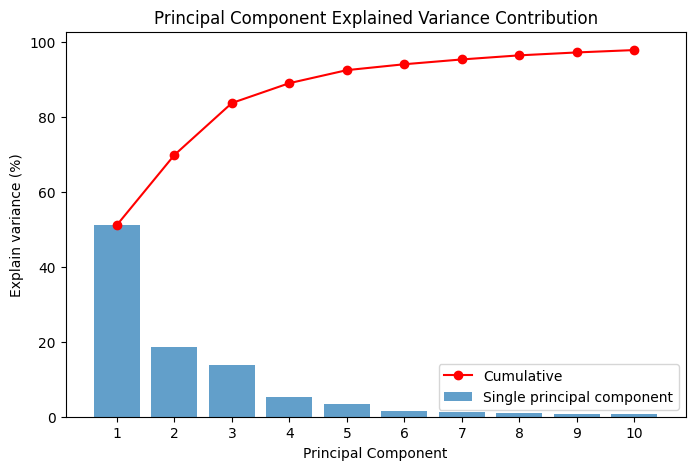

In [9]:
# Apply PCA Dimensionality Reduction After Standardizing the Data
X = data_by_year.fillna(data_by_year.mean())         # Fill missing values with the mean of each indicator
X_scaled = StandardScaler().fit_transform(X)         # Standardization
pca = PCA()
pca.fit(X_scaled)
explained_var_ratio = pca.explained_variance_ratio_  # Proportion of variance explained by each principal component

# Plotting histograms and cumulative curves of variance explained for the first 10 principal components
plt.figure(figsize=(8, 5))
plt.bar(range(1, 11), explained_var_ratio[:10] * 100, alpha=0.7, label='Single principal component')
plt.plot(range(1, 11), np.cumsum(explained_var_ratio[:10]) * 100, marker='o', color='red', label='Cumulative')
plt.xticks(range(1, 11))
plt.title('Principal Component Explained Variance Contribution')
plt.xlabel('Principal Component')
plt.ylabel('Explain variance (%)')
plt.legend()
plt.show()

# KMeans Clustering and PCA Visualization

The KMeans algorithm was used to divide data samples into several clusters, utilizing all available features: **region**, **indicator type**, **year**, and **indicator values**. The following preprocessing and visualization steps were applied:

1. **Preprocessing**:
   - **Standardization**: Numerical features (year and indicator values) were standardized to ensure consistent scaling.
   - **One升高 encoding**: Categorical features (region and indicator type) were one-hot encoded to allow proper influence on distance measurements in clustering.

2. **Clustering**:
   - The KMeans algorithm was applied to the preprocessed features to form clusters.

3. **Visualization**:
   - **Principal Component Analysis (PCA)** was used to reduce the high-dimensional feature space to two dimensions.
   - This enabled intuitive visualization and analysis of the cluster distributions in a 2D scatter plot.



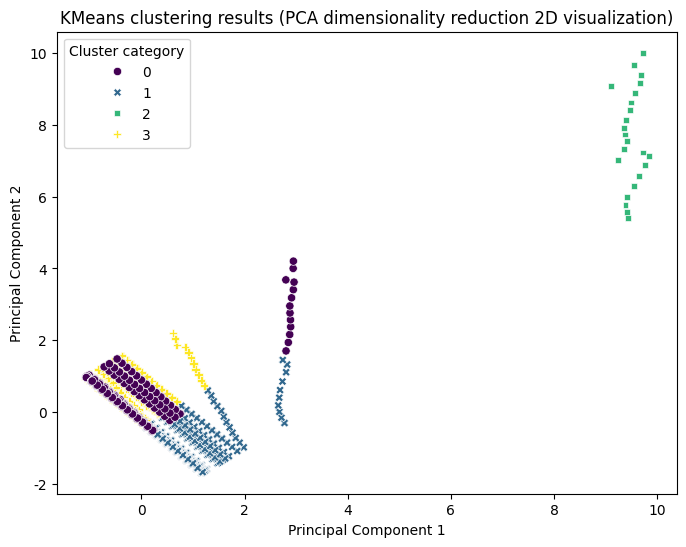

In [10]:
# Extract Features and Target Variable
features = df[['area', 'item', 'Year_num']]  # Region, Indicator Type, Year as Features
target = df['value']                     # Indicator value as the target variable

# One-hot encode categorical features, converting categorical variables into numerical columns
features_dummies = pd.get_dummies(features, columns=['area', 'item'], drop_first=False)
cluster_data = features_dummies.copy()
cluster_data['value'] = target.values

#Standardize the year and numerical columns (mean = 0, standard deviation = 1)
scaler = StandardScaler()
cluster_data[['Year_num', 'value']] = scaler.fit_transform(cluster_data[['Year_num', 'value']])

#Clustering using KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(cluster_data)

# Add clustering labels back to the original data frame for analysis
df['Cluster'] = cluster_labels

# Use PCA to downscale data to 2D for easy visualization
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(cluster_data)

# Place the PCA results into a DataFrame and add the corresponding cluster tags
pca_df = pd.DataFrame({'PC1': pca_result[:, 0], 'PC2': pca_result[:, 1], 'Cluster': cluster_labels})

# Plot a 2D scatterplot of the clustering results, colored by cluster labels
plt.figure(figsize=(8,6))
plt.rcParams['axes.unicode_minus'] = False    
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', style='Cluster')
plt.title("KMeans clustering results (PCA dimensionality reduction 2D visualization)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster category')
plt.show()

# PCA Visualization Analysis of KMeans Clustering

This scatter plot visualizes samples clustered by KMeans after reducing high-dimensional features (one-hot encoded 'region' and 'indicator type', standardized 'year' and 'value') to two dimensions using PCA. Below is a detailed interpretation:

## 1. Meaning of the Axes
- The **horizontal axis (Principal Component 1)** and **vertical axis (Principal Component 2)** represent the first two principal components, capturing the largest and second-largest variance directions in the data, respectively.
- Larger values indicate that samples align more with the feature combinations represented by each component.

## 2. Markers and Colors of Points
- **Cluster 0**: Purple ●
- **Cluster 1**: Blue ×
- **Cluster 2**: Green ■
- **Cluster 3**: Yellow +

## 3. Separation Between Clusters
- **Cluster 2 (Green ■)**:
  - Positioned far right (PC1 ≈ 8.5–10), dispersed along PC2.
  - Significantly distinct from other clusters in original features, making it easily distinguishable.
- **Cluster 0 (Purple ●)**:
  - Concentrated in a vertical band (PC1 ≈ 2.5–3.5, PC2 ≈ 3.0–4.5).
  - Internally compact, indicating high consistency along main variance directions.
- **Cluster 1 (Blue ×)**:
  - Forms a diagonal band from upper left to lower right (PC1 ≈ 0.5–2.5, PC2 ≈ 1.5 to –1.5).
  - Shows greater variation in certain feature dimensions, forming a “gradient” shaped cluster.
- **Cluster 3 (Yellow +)**:
  - Gathers in the upper left (PC1 ≈ 0–1.2, PC2 ≈ 0.8–2.2).
  - Slightly overlaps with Cluster 1 at the boundary, suggesting some feature similarity.

## 4. Clustering Quality
- **Good Separation**:
  - Cluster 2 and Cluster 0 show almost no overlap in the two principal component spaces, indicating internal consistency and clear distinction from other clusters.
- **Blurred Boundaries**:
  - Cluster 1 and Cluster 3 intersect where PC1 < 2, suggesting potential “transitional” samples between these clusters in the original multidimensional space.

## Summary
The PCA visualization confirms the 4-cluster structure. Clusters 0 and 2 are distinctly separated, while Clusters 1 and 3 exhibit partially overlapping boundaries, indicating some feature similarity.


# Elbow Method:SSE vs. n_clusters

By calculating the curve of SSE (sum of squared errors within clusters, also known as inertia_) under different k values as k changes, it helps to select the optimal number of clusters.

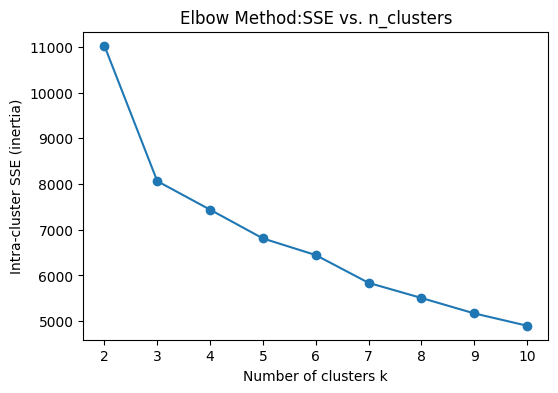

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = []
ks = range(2, 11)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(cluster_data)
    sse.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(ks, sse, marker='o')
plt.title('Elbow Method:SSE vs. n_clusters')
plt.xlabel('Number of clusters k')
plt.ylabel('Intra-cluster SSE (inertia)')
plt.xticks(ks)
plt.show()

# Average silhouette coefficient silhouette_score

Measures the ratio of the tightness of samples within their own cluster to the separation from the nearest cluster; the closer to 1, the better.
Sample-level silhouette coefficient silhouette_samples: can be used to plot silhouette diagrams to see the distribution of each point within its respective cluster.

Average Silhouette Coefficient: 0.169


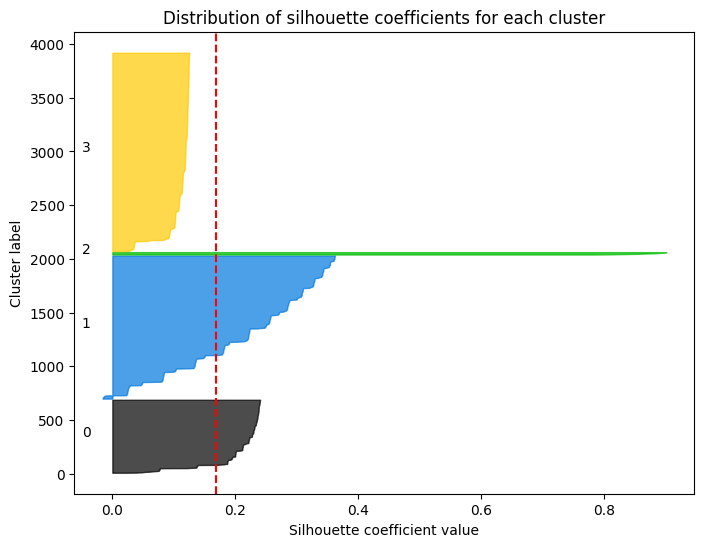

In [12]:
sil_avg = silhouette_score(cluster_data, cluster_labels)
print(f'Average Silhouette Coefficient: {sil_avg:.3f}')

sample_sil_values = silhouette_samples(cluster_data, cluster_labels)
y_lower = 10
n_clusters = len(np.unique(cluster_labels))
plt.figure(figsize=(8,6))

for i in range(n_clusters):
    ith_cluster_sil_vals = sample_sil_values[cluster_labels == i]
    ith_cluster_sil_vals.sort()
    size_cluster_i = ith_cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_sil_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # Leave blank for the next cluster

plt.title("Distribution of silhouette coefficients for each cluster")
plt.xlabel("Silhouette coefficient value")
plt.ylabel("Cluster label")
plt.axvline(x=sil_avg, color="red", linestyle="--")
plt.show()

# Silhouette Coefficient Distribution Analysis

This figure illustrates the distribution of the Silhouette Coefficient for each sample across four clusters. The horizontal axis represents the silhouette coefficient value (ranging from –1 to 1), and the vertical axis denotes the cluster label. Each “stripe” corresponds to the silhouette coefficients of all samples within a cluster, sorted and stacked.

- The **red dashed line** marks the average silhouette coefficient of all samples (~0.17), serving as a baseline for overall clustering quality.
- Silhouette coefficient interpretation:
  - Close to **1**: Sample is close to other points in its own cluster and far from the nearest other cluster.
  - Close to **0**: Sample lies on the boundary between two clusters.
  - **Negative values**: Suggest possible misclassification.

## Conclusion
The overall average silhouette coefficient of ~0.17 indicates a "weak" to "moderate" clustering effect. **Cluster 1** and **Cluster 2** perform better, while **Cluster 3** requires the most optimization.

## Cluster-Specific Analysis
1. **Cluster 1 (Blue)**
   - Distribution ranges from ~0 to 0.35, with most points to the right of the average line.
   - Relatively compact internally and well-separated from other clusters, making it the **best-performing** cluster.

2. **Cluster 2 (Green)**
   - Appears as a thin, elongated band, with values concentrated around 0.20, slightly above the average line.
   - Likely a smaller sample size but internally consistent, with **medium to high quality**.

3. **Cluster 0 (Gray-black)**
   - Distributed between ~0 and 0.30, hovering around the average line, with some samples below it, indicating occasional boundary points.
   - Relatively stable but with **room for improvement**.

4. **Cluster 3 (Yellow)**
   - Most values concentrated between ~0 and 0.15, significantly below the average line.
   - Indicates low internal compactness and overlapping boundaries with other clusters, resulting in the **worst clustering performance**.



# t-SNE visualization of clustering

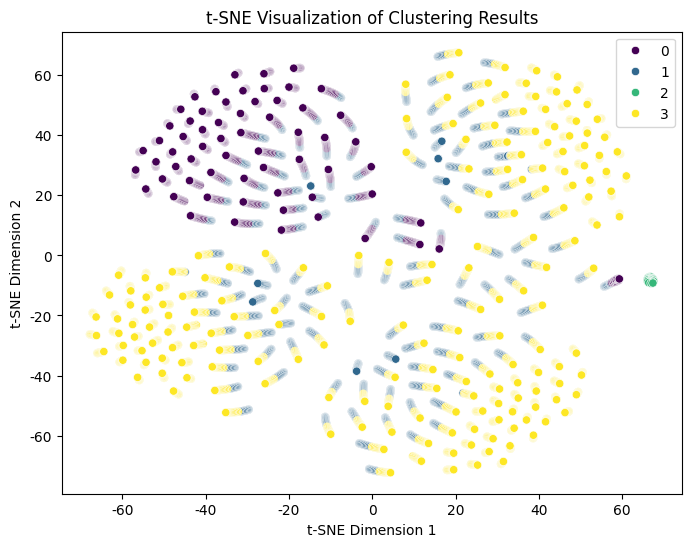

In [13]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(cluster_data)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=tsne_result[:,0], y=tsne_result[:,1],
    hue=cluster_labels, palette='viridis', legend='full'
)
plt.title("t-SNE Visualization of Clustering Results")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# t-SNE Visualization Analysis

## 1. Meaning of the Points
- Each point represents a sample from the original dataset, encompassing four-dimensional information: one-hot encoded "region" and "indicator type", standardized "year" and "value".

## 2. Axes
- t-SNE Dimension 1 and Dimension 2 are the "projected coordinates" after dimensionality reduction, used solely to evaluate the relative distance and distribution between points.

## 3. Cluster Distribution
- **Cluster 0 (Purple)**: Concentrated in the upper left, forming a compact cluster, indicating high similarity among these samples in the original feature space.
- **Cluster 3 (Yellow)**: Distributed on the right side and lower left, relatively concentrated, representing a distinctly different sample group.
- **Cluster 1 (Teal)**: Positioned between the purple and yellow clusters, forming a “bridge” or transition zone, suggesting these samples share features with both Cluster 0 and Cluster 3.
- **Cluster 2 (Light Green)**: A smaller, isolated cluster on the far right, indicating significant differences from other clusters, possibly representing a unique type or outliers.

## 4. Cluster Gaps and Overlaps
- Clear gaps between clusters indicate that KMeans effectively partitions the high-dimensional space.
- Slight mixing at the boundaries of Cluster 1 and Cluster 3 suggests these samples are challenging to distinguish fully, marking them as key “ambiguous” areas for further optimization (e.g., parameter tuning or alternative algorithms).

## 5. t-SNE Characteristics
- t-SNE prioritizes preserving “local similarity,” grouping points close in high-dimensional space together, but significantly distorts the global structure.
- “Ring-shaped” or “spiral-shaped” distributions in the plot are artifacts of t-SNE’s projection method to separate local clusters and do not reflect geometric shapes in the original space.

## Summary
This t-SNE visualization confirms that the 4 clusters identified by KMeans remain well-separated after dimensionality reduction. Clusters 0 and 3 exhibit clear distributions, while Cluster 1 shows "transitional" characteristics, and Cluster 2 indicates "outlier" traits. The cluster structure is reliable and interpretable.


In [14]:
# Extract the value sequence and convert it to a numpy array
values = df['value'].values.astype(float)
n_total = len(values)
# Divide the training set and test set according to 80/20
train_size = int(n_total * 0.8)
train_values = values[:train_size]
test_values = values[train_size:]

# Normalization: fitting with training set statistics
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_values.reshape(-1,1)).flatten()
test_scaled = scaler.transform(test_values.reshape(-1,1)).flatten()

# Sliding Window Generator Functions
def create_window_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 3
# Construct training set sliding window
X_train, y_train = create_window_dataset(train_scaled, window_size)
# Construct a sliding window of test sets (allowing the use of the end of the training set as part of the test input)
combined_scaled = np.concatenate([train_scaled, test_scaled])
X_test, y_test = create_window_dataset(combined_scaled, window_size)
# Only samples with target values in the test set portion are retained
X_test = X_test[ train_size-window_size: ]
y_test = y_test[ train_size-window_size: ]

# Adjust data dimensions to match model input format (number of samples, time step, number of features)
X_train = X_train.reshape(-1, window_size, 1)
X_test  = X_test.reshape(-1, window_size, 1)
y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

print("Number of training samples:", X_train.shape[0], "  Number of test set samples:", X_test.shape[0])

Number of training samples: 3101   Number of test set samples: 776


In [15]:
# Constructing LSTM Models
tf.keras.backend.clear_session()
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(window_size, 1)),
    tf.keras.layers.Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Model Training
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=100, batch_size=4, verbose=0
)

# Predict on the test set
y_pred_lstm = lstm_model.predict(X_test)
# Back-normalized back to the original scale
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

# Calculation Error
mse_lstm = mean_squared_error(y_test_inv, y_pred_lstm_inv)
rmse_lstm = math.sqrt(mse_lstm)
print(f"LSTM: MSE={mse_lstm:.3f}, RMSE={rmse_lstm:.3f}")

c:\Users\Yukino\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM: MSE=13744.073, RMSE=117.235


In [16]:
# Training set actual & predicted (after inverse normalization)
y_pred_train = lstm_model.predict(X_train)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
y_train_inv     = scaler.inverse_transform(y_train)

df_train = pd.DataFrame({
    'index': np.arange(len(y_train_inv)),
    'actual': y_train_inv.flatten(),
    'predicted': y_pred_train_inv.flatten()
})

df_test = pd.DataFrame({
    'index': np.arange(len(y_test_inv)),
    'actual': y_test_inv.flatten(),
    'predicted': y_pred_lstm_inv.flatten()
})

# 1. Predicted Values vs Actual Values Line Chart

def plot_pred_vs_actual(df, title):
    fig = px.line(df, x='index', y=['actual','predicted'],
                  labels={'value':'value','index':'index'},
                  title=title)
    fig.data[0].name = 'Actual value'
    fig.data[1].name = 'Predicted value'
    fig.update_layout(legend_title_text='Legend')
    fig.show()

plot_pred_vs_actual(df_train, 'LSTM Training Set: Predicted Values vs Actual Values')
plot_pred_vs_actual(df_test,  'LSTM Test set: Predicted values vs Actual values')


# 2. Residual Distribution Histogram

for df, tag in [(df_train, 'LSTM Training Set'), (df_test, 'LSTM Test set')]:
    df['residual'] = df['predicted'] - df['actual']
    fig = px.histogram(df, x='residual', nbins=20,
                       labels={'residual':'Residuals','count':'Frequency'},
                       title=f'{tag}:Residual distribution')
    fig.show()


# 3. Loss Variation with Epochs

loss_values = history_lstm.history['loss']
df_loss = pd.DataFrame({
    'epoch': np.arange(1, len(loss_values)+1),
    'loss': loss_values
})

fig = px.line(df_loss, x='epoch', y='loss',
              labels={'epoch':'Epoch','loss':'Training Loss'},
              title='LSTM Training loss with Epoch')
fig.update_traces(mode='lines+markers')
fig.show()

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


# LSTM Model Visualization Analysis

The LSTM model's visualization results demonstrate convergence and reasonable fitting but reveal clear biases and limitations in handling certain patterns.

---

## 1. Training Set & Test Set: Predicted Values vs Actual Values

### Training Set Curve
- The red predicted curve aligns closely with the blue actual curve in most intervals, indicating the model captures temporal patterns in the training data effectively.
- At “peak” positions (e.g., large spikes reaching tens of thousands), predictions lag and significantly underestimate the actual values.

### Test Set Curve
- In high-peak regions (sample index ~700–750), the model fails to capture rapid rises and falls, with predictions consistently lower than actual values.
- In stable or slowly changing intervals, predictions are close to actual values, though slight lead or lag deviations occur occasionally.

**Conclusion**: The model captures general trends but struggles with drastic fluctuations, particularly large increases, showing a tendency for “over-smoothing” and systematic underestimation.

---

## 2. Residual Distribution

### Training Set Residuals
- Most residuals are concentrated near 0, indicating small errors in a narrow range.
- Long tails exist at both positive (overestimation) and negative (underestimation) ends, with extreme values corresponding to large errors at peak moments.
- Using more bins (e.g., nbins=50) highlights that peak errors are concentrated in specific intervals.

### Test Set Residuals
- Residuals are mainly centered near 0 but show more negative values (predictions below actuals), with negative skewness confirming systematic underestimation.
- Extreme negative residuals indicate errors reaching thousands or tens of thousands for some samples.

**Conclusion**: The residual distribution is not zero-mean normal, exhibiting negative skewness and heavy tails, confirming model bias and occasional large errors (outliers).

---

## 3. Training Loss Variation Over Epochs
- Loss decreases sharply within the first 10–20 epochs, then stabilizes and oscillates around a low value (~5–6×10⁻⁴), indicating convergence.
- No clear overfitting is observed (training loss does not increase), but the converged loss value suggests the model has reached its capacity limit under the current structure and parameters.

**Conclusion**: The training process converges well, but the convergence level indicates insufficient model capacity or input features to further reduce errors.

---

## Comprehensive Evaluation

### Advantages
- Stably learns general temporal patterns with smooth training convergence.
- Performs well in smoothly varying intervals, with small prediction errors and good noise resistance.

### Disadvantages
- **Systematic underestimation**: Predictions lag and are biased low during large fluctuations.
- **Long tail of large errors**: Residual distribution shows heavy tails with frequent extreme errors.
- **Limited model capacity/features**: The single-layer LSTM with a single neuron output struggles to capture complex and abrupt patterns.


In [19]:
# Building a 1D CNN Model
tf.keras.backend.clear_session()
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu',
                           input_shape=(window_size, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mse')

# Model Training
history_cnn = cnn_model.fit(
    X_train, y_train,
    epochs=100, batch_size=4, verbose=0
)

# Model Training
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn_inv = scaler.inverse_transform(y_pred_cnn)

# Calculation Error
mse_cnn = mean_squared_error(y_test_inv, y_pred_cnn_inv)
rmse_cnn = math.sqrt(mse_cnn)
print(f"CNN: MSE={mse_cnn:.3f}, RMSE={rmse_cnn:.3f}")

c:\Users\Yukino\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CNN: MSE=16035.467, RMSE=126.631


In [18]:
# Prepare DataFrame

# Training Set Prediction & Inverse Normalization
y_pred_train_cnn = cnn_model.predict(X_train)
y_pred_train_cnn_inv = scaler.inverse_transform(y_pred_train_cnn)
y_train_inv = scaler.inverse_transform(y_train)

df_train_cnn = pd.DataFrame({
    'index': np.arange(len(y_train_inv)),
    'actual': y_train_inv.flatten(),
    'predicted': y_pred_train_cnn_inv.flatten()
})

# Test Set Prediction & Inverse Normalization
df_test_cnn = pd.DataFrame({
    'index': np.arange(len(y_test_inv)),
    'actual': y_test_inv.flatten(),
    'predicted': y_pred_cnn_inv.flatten()
})

# 1. Predicted vs Actual Line Chart

def plot_pred_vs_actual(df, title):
    fig = px.line(df, x='index', y=['actual','predicted'],
                  labels={'value':'value','index':'index'},
                  title=title)
    fig.data[0].name = 'Actual value'
    fig.data[1].name = 'Predicted value'
    fig.update_layout(legend_title_text='Legend')
    fig.show()

plot_pred_vs_actual(df_train_cnn, 'CNN Training Set: Predicted Values vs Actual Values')
plot_pred_vs_actual(df_test_cnn,  'CNN Test Set: Predicted Values vs Actual Values')

# 2. Residual Distribution Histogram

for df, tag in [(df_train_cnn, 'CNN Training Set'), (df_test_cnn, 'CNN Test Set')]:
    df['residual'] = df['predicted'] - df['actual']
    fig = px.histogram(df, x='residual', nbins=20,
                       labels={'residual':'Residuals','count':'Frequency'},
                       title=f'{tag}：Residual distribution')
    fig.show()


# 3. 损失随 Epoch 变化

loss_values_cnn = history_cnn.history['loss']
df_loss_cnn = pd.DataFrame({
    'epoch': np.arange(1, len(loss_values_cnn)+1),
    'loss': loss_values_cnn
})

fig = px.line(df_loss_cnn, x='epoch', y='loss',
              labels={'epoch':'Epoch','loss':'Training Loss'},
              title='CNN training loss changes with Epoch')
fig.update_traces(mode='lines+markers')
fig.show()

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step


# CNN Model Visualization Analysis

The CNN model's visualization results highlight its performance in predicting time-series data, compared to the LSTM model, showing improved handling of sudden changes and overall efficiency.

## 1. Predicted Values vs Actual Values (Training Set & Test Set)

### Training Set
- In stable or slightly fluctuating segments, the CNN's red predicted curve closely overlaps with the blue actual curve, indicating excellent fit to the training data.
- At peak regions (sample indices ~2000–2100, 3000–3050), the CNN predicts closer to actual peak values than LSTM, with reduced underestimation and a faster, sharper response to surges.

### Test Set
- At major peaks (segments ~700–750 and 0–50), CNN predictions are closer to true values than LSTM, capturing rising and falling trends with slight lag.
- In stable segments, errors are minimal, with predicted and actual curves nearly overlapping, demonstrating strong generalization.

**Summary**: CNN outperforms LSTM in capturing sudden changes (peaks) and excels at recognizing local surge patterns within sliding windows. In smooth intervals, both models perform similarly.

---

## 2. Residual Distribution (Training Set & Test Set)

### Training Set Residuals
- Most residuals are tightly concentrated near 0, indicating small errors for the majority of samples.
- Compared to LSTM, CNN has fewer extreme residuals (long tail), with a sharper, more symmetric distribution, reduced skewness, and lower kurtosis.

### Test Set Residuals
- Centered near 0 with improved symmetry. Negative residuals (underestimation) slightly outnumber positive residuals (overestimation), but both magnitude and frequency are significantly lower than LSTM.
- Extreme errors (>2000 or <–1000) are rare, indicating greater robustness on the test set.

**Summary**: CNN's residual distribution is more concentrated, closer to zero, with flattened long-tail “spikes,” demonstrating better performance than LSTM in reducing large errors.

---

## 3. Training Loss Variation Over Epochs
- CNN training loss drops rapidly to ~8×10⁻⁴ within 5–10 epochs, then gradually converges near 6×10⁻⁴.
- Compared to)
- Compared to LSTM (final loss ~5.8×10⁻⁴), CNN’s convergence curve is steeper and smoother, with fewer fluctuations in later stages.
- CNN achieves similar loss values with fewer epochs, leveraging its simpler architecture (single convolutional layer + fully connected) for more efficient generalization.

**Summary**: CNN converges faster with a stable loss curve, indicating efficient parameter updates. Its final loss is comparable to LSTM, but the simpler architecture enhances training efficiency and robustness.

---

## Comprehensive Evaluation
1. **Fitting Performance**: CNN excels in both stable and sudden-change intervals, particularly capturing peak fluctuations more accurately than LSTM.
2. **Error Characteristics**: Residuals are more concentrated, with fewer extreme errors and a better bias-variance tradeoff.
3. **Training Efficiency**: CNN converges faster with a smoother loss curve, demonstrating that its architecture is more efficient and robust.
